# Image processing coursework 1

## Loading in images and dependencies

(2814, 2110, 3)
(2814, 2110, 3)


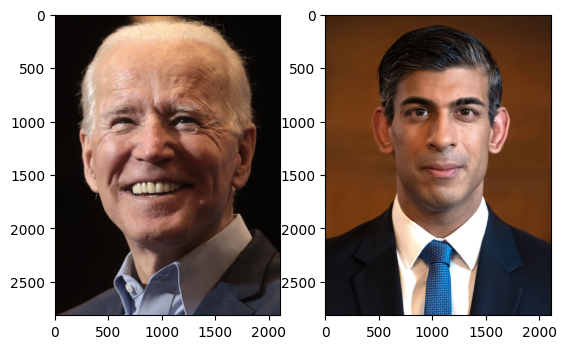

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial import Delaunay
import dlib, cv2
import os

image1 = plt.imread('Images\Joe_Biden.jpg')
image2 = plt.imread('Images\Sunak.jpg')
image2 = np.copy(image2[0:2814, 100:2210,:])
print(image1.shape)
print(image2.shape)
plt.subplot(1, 2, 1)
plt.imshow(image1)
plt.subplot(1, 2, 2)
plt.imshow(image2)


Get the landmark detector

In [2]:
dat_path = 'shape_predictor_68_face_landmarks.dat'
file_path = 'shape_predictor_68_face_landmarks.dat.bz2'
url = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
 
if not os.path.exists(dat_path):
    os.system('wget {} -O {}'.format(url, file_path))
    os.system('bunzip2 {} '.format(file_path))

## Detecting facial landmarks

In [5]:
def shape_to_np(shape, dtype="int"):
    coords = np.zeros((68, 2), dtype=dtype)
    for i in range(68):
        coords[i,0] = shape.part(i).x
        coords[i,1] = shape.part(i).y
    return coords

def landmark_detector(img):
    
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
    rects = detector(img, 1)
    rect = rects[0]
    shape = predictor(img, rect)
    shape = shape_to_np(shape)
    return shape

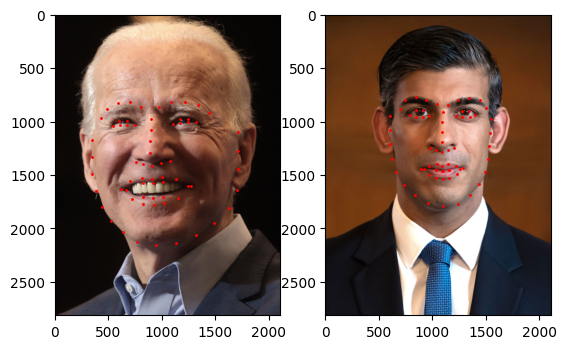

In [6]:
landmark1 = landmark_detector(image1)
landmark2 = landmark_detector(image2)
plt.subplot(1, 2, 1)
plt.scatter(landmark1[:, 0], landmark1[:,1], s=1, color='red')
plt.imshow(image1)
plt.subplot(1, 2, 2)
plt.scatter(landmark2[:, 0], landmark2[:,1], s=1, color='red')
plt.imshow(image2)